<a href="https://colab.research.google.com/github/wujinja-cgu/Time-Series-Analysis/blob/main/time_series_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydlm
from pydlm import dlm, trend, seasonality
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
url='https://raw.githubusercontent.com/wujinja-cgu/Time-Series-Analysis/main/time%20series%20data.csv'
df = pd.read_csv(url, index_col='DATE', parse_dates=["DATE"])
df.head()

,No
DATE,
2007-10-09,325
2007-10-10,417
2007-10-11,556
2007-10-12,467
2007-10-13,430


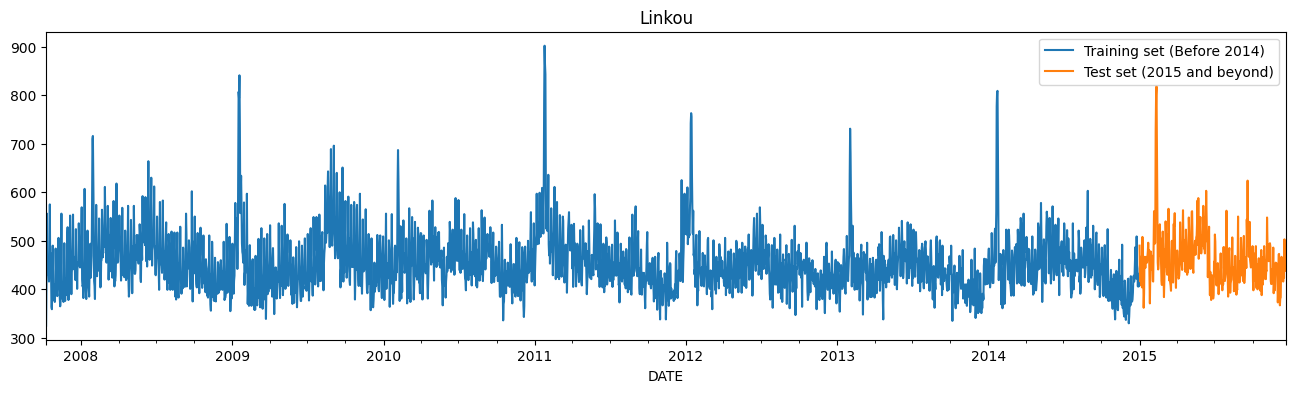

In [3]:
import matplotlib.pyplot as plt
# Plot the training set
df["No"][:'2014'].plot(figsize=(16, 4), legend=True)
# Plot the test set
df["No"]['2015':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2014)', 'Test set (2015 and beyond)'])
plt.title('Linkou')
plt.show()

In [4]:
# here we are seperating the data
trainning_set = df[:'2014'].iloc[:,0:1].values
test_set = df['2015':].iloc[:,0:1].values
trainning_set

array([[325],
       [417],
       [556],
       ...,
       [432],
       [406],
       [429]])

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(trainning_set)
training_set_scaled

array([[0.        ],
       [0.15944541],
       [0.40034662],
       ...,
       [0.18544194],
       [0.14038128],
       [0.18024263]])

In [6]:
import numpy as np

X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=32))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')

In [8]:
history = regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
81/81 [==============================] - 44s 400ms/step - loss: 0.0108
Epoch 2/50
81/81 [==============================] - 33s 412ms/step - loss: 0.0097
Epoch 3/50
81/81 [==============================] - 34s 416ms/step - loss: 0.0096
Epoch 4/50
81/81 [==============================] - 32s 401ms/step - loss: 0.0092
Epoch 5/50
81/81 [==============================] - 34s 412ms/step - loss: 0.0090
Epoch 6/50
81/81 [==============================] - 32s 396ms/step - loss: 0.0087
Epoch 7/50
81/81 [==============================] - 34s 418ms/step - loss: 0.0086
Epoch 8/50
81/81 [==============================] - 32s 393ms/step - loss: 0.0084
Epoch 9/50
81/81 [==============================] - 32s 394ms/step - loss: 0.0086
Epoch 10/50
81/81 [==============================] - 33s 411ms/step - loss: 0.0086
Epoch 11/50
81/81 [==============================] - 33s 401ms/step - loss: 0.0084
Epoch 12/50
81/81 [==============================] - 32s 392ms/step - loss: 0.0081
Epoch 13/50
8

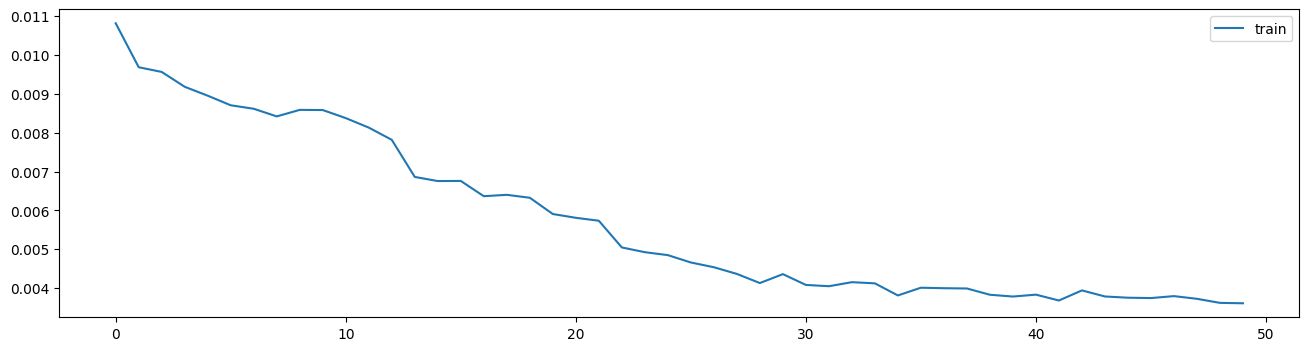

In [21]:
# plot history
plt.figure(figsize=(16,4))
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
# pre-processing the data
dataset_total = pd.concat((df["No"][:'2014'],df["No"]['2015':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(60,len(inputs)):
  X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

12/12 [==============================] - 3s 106ms/step


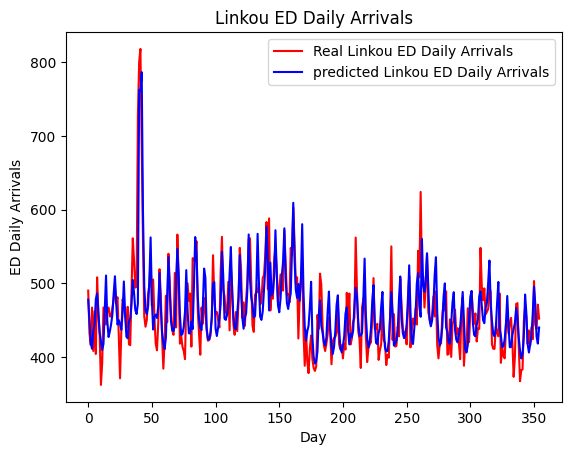

In [10]:
def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real Linkou ED Daily Arrivals")
    plt.plot(prediction, color="blue",label="predicted Linkou ED Daily Arrivals")
    plt.title("Linkou ED Daily Arrivals")
    plt.xlabel("Day")
    plt.ylabel("ED Daily Arrivals")
    plt.legend()
    plt.show()
# now we'll use this function to visualize our test and predicted data

plot_prediction(test_set,predicted_stock_price)

In [11]:
len(predicted_stock_price)

355

In [12]:
test_set
len(test_set)

355

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(np.array(test_set), np.array(predicted_stock_price)))
print("The root mean squared error is {}.".format(rms))

The root mean squared error is 35.87705911514744.


In [14]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

#trainmape = mape(trainY[0], trainPredict[:,0])
#print('Train MPAE: %.2f' % (trainmape))
testmape = mape(np.array(test_set), np.array(predicted_stock_price))
print('Test MAPE: %.2f' % (testmape))

Test MAPE: 5.57


Epoch 1/50
81/81 [==============================] - 132s 1s/step - loss: 0.0142
Epoch 2/50
81/81 [==============================] - 122s 2s/step - loss: 0.0098
Epoch 3/50
81/81 [==============================] - 119s 1s/step - loss: 0.0099
Epoch 4/50
81/81 [==============================] - 121s 1s/step - loss: 0.0095
Epoch 5/50
81/81 [==============================] - 120s 1s/step - loss: 0.0093
Epoch 6/50
81/81 [==============================] - 122s 2s/step - loss: 0.0088
Epoch 7/50
81/81 [==============================] - 120s 1s/step - loss: 0.0088
Epoch 8/50
81/81 [==============================] - 122s 2s/step - loss: 0.0091
Epoch 9/50
81/81 [==============================] - 118s 1s/step - loss: 0.0086
Epoch 10/50
81/81 [==============================] - 116s 1s/step - loss: 0.0086
Epoch 11/50
81/81 [==============================] - 115s 1s/step - loss: 0.0085
Epoch 12/50
81/81 [==============================] - 117s 1s/step - loss: 0.0083
Epoch 13/50
81/81 [==================

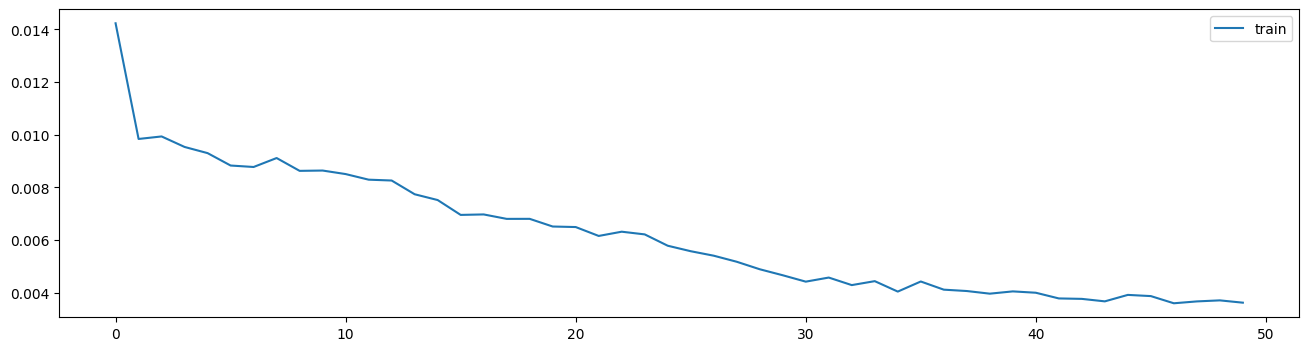

In [22]:
regressor1 = Sequential()
# First LSTM layer with Dropout regularisation
regressor1.add(LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor1.add(Dropout(0.3))

regressor1.add(LSTM(units=256, return_sequences=True))
regressor1.add(Dropout(0.2))

regressor1.add(LSTM(units=128, return_sequences=True))
regressor1.add(Dropout(0.1))

regressor1.add(LSTM(units=64, return_sequences=True))
regressor1.add(Dropout(0.2))

regressor1.add(LSTM(units=32))
regressor1.add(Dropout(0.3))

regressor1.add(Dense(units=1))


regressor1.compile(optimizer='adam',loss='mean_squared_error')

history1 = regressor1.fit(X_train, y_train, epochs=50, batch_size=32)

# plot history
plt.figure(figsize=(16,4))
plt.plot(history1.history['loss'], label='train')
plt.legend()
plt.show()

In [24]:
# pre-processing the data
dataset_total = pd.concat((df["No"][:'2014'],df["No"]['2015':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(60,len(inputs)):
  X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price_LSTM1 = regressor1.predict(X_test)
predicted_stock_price_LSTM1 = sc.inverse_transform(predicted_stock_price_LSTM1)

12/12 [==============================] - 5s 440ms/step


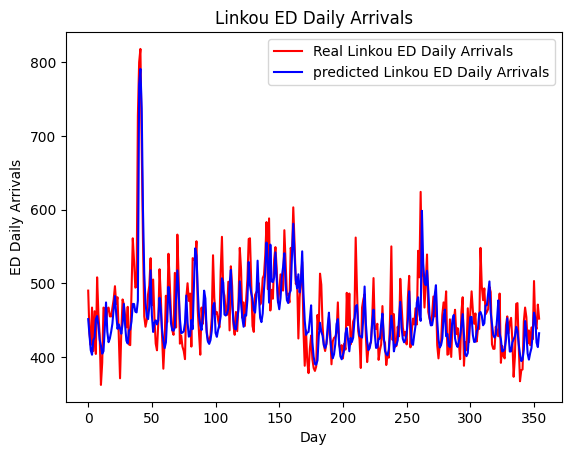

In [25]:
def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real Linkou ED Daily Arrivals")
    plt.plot(prediction, color="blue",label="predicted Linkou ED Daily Arrivals")
    plt.title("Linkou ED Daily Arrivals")
    plt.xlabel("Day")
    plt.ylabel("ED Daily Arrivals")
    plt.legend()
    plt.show()
# now we'll use this function to visualize our test and predicted data

plot_prediction(test_set,predicted_stock_price_LSTM1)

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_LSTM1 = sqrt(mean_squared_error(np.array(test_set), np.array(predicted_stock_price_LSTM1)))
print("The root mean squared error is {}.".format(rms_LSTM1))

The root mean squared error is 36.4910943398389.


In [27]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

#trainmape = mape(trainY[0], trainPredict[:,0])
#print('Train MPAE: %.2f' % (trainmape))
testmape_LSTM1 = mape(np.array(test_set), np.array(predicted_stock_price_LSTM1))
print('Test MAPE: %.2f' % (testmape_LSTM1))

Test MAPE: 5.65


In [15]:
from tensorflow.keras.layers import GRU
regressorGRU = Sequential()

regressorGRU.add(GRU(units=256, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.3))
# Second GRU layer
regressorGRU.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.1))
# Fourth GRU layer
regressorGRU.add(GRU(units=32, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')

# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
18/18 [==============================] - 27s 819ms/step - loss: 0.0145
Epoch 2/50
18/18 [==============================] - 19s 1s/step - loss: 0.0095
Epoch 3/50
18/18 [==============================] - 17s 947ms/step - loss: 0.0090
Epoch 4/50
18/18 [==============================] - 17s 935ms/step - loss: 0.0088
Epoch 5/50
18/18 [==============================] - 24s 1s/step - loss: 0.0085
Epoch 6/50
18/18 [==============================] - 18s 1s/step - loss: 0.0087
Epoch 7/50
18/18 [==============================] - 15s 818ms/step - loss: 0.0087
Epoch 8/50
18/18 [==============================] - 15s 817ms/step - loss: 0.0086
Epoch 9/50
18/18 [==============================] - 15s 818ms/step - loss: 0.0083
Epoch 10/50
18/18 [==============================] - 15s 817ms/step - loss: 0.0078
Epoch 11/50
18/18 [==============================] - 15s 818ms/step - loss: 0.0078
Epoch 12/50
18/18 [==============================] - 15s 853ms/step - loss: 0.0070
Epoch 13/50
18/18 [===

In [16]:
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price_GRU = regressorGRU.predict(X_test)
predicted_stock_price_GRU = sc.inverse_transform(predicted_stock_price_GRU)

12/12 [==============================] - 3s 80ms/step


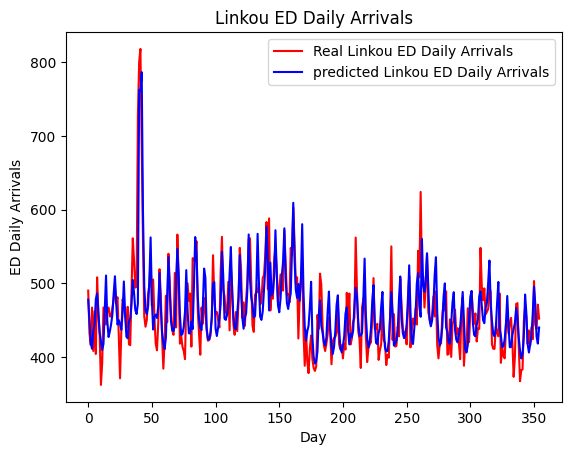

In [17]:
plot_prediction(test_set,predicted_stock_price)

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_GRU = sqrt(mean_squared_error(np.array(test_set), np.array(predicted_stock_price_GRU)))
print("The root mean squared error is {}.".format(rms_GRU))

The root mean squared error is 37.230382903399715.


In [19]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

#trainmape = mape(trainY[0], trainPredict[:,0])
#print('Train MPAE: %.2f' % (trainmape))
testmape_GRU = mape(np.array(test_set), np.array(predicted_stock_price_GRU))
print('Test MAPE: %.2f' % (testmape_GRU))

Test MAPE: 5.66
